<a href="https://colab.research.google.com/github/nielsrolf/audio_playground/blob/master/SirenWavAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tf_siren

In [2]:
!pip install youtube-dl

     |████████████████████████████████| 1.8MB 5.3MB/s 


# Download soma audio data

In [ ]:
!youtube-dl https://soundcloud.com/thomash_voodoohop/thomash-all-my-pretty-horses

In [ ]:
!ffmpeg -i 'Thomash - All My Pretty Monkeys-251418259.mp3' data.wav 

# Load the data

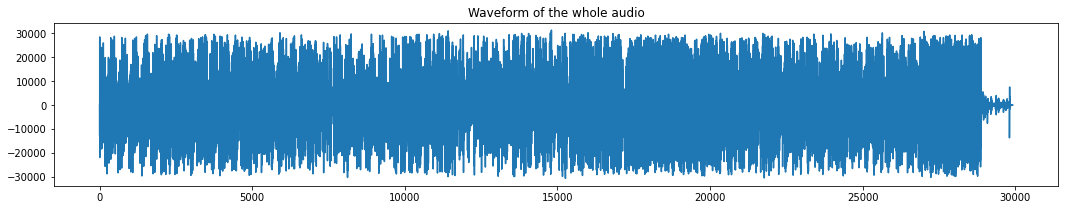

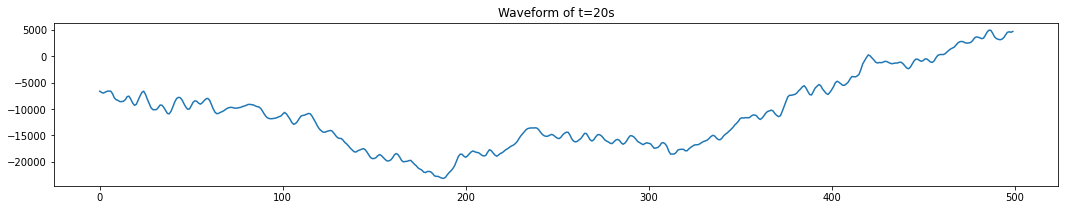

In [12]:
from scipy.io import wavfile
from matplotlib import pyplot as plt

sr, wav = wavfile.read("data.wav")
wav = wav.mean(1) # stereo -> mono
wav.shape, sr

plt.figure(figsize=(18, 3))
plt.plot(wav[::sr//100])
plt.title("Waveform of the whole audio")
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(wav[sr*20:sr*20+500])
plt.title("Waveform of t=20s")
plt.show()

In [16]:
from IPython.display import display, Audio

display(Audio(wav[sr*10:sr*20], rate=sr))

# Preprocessing

The idea is to train an autoencoder, where the decoder is a SIREN model and the encoder predicts its weights.

**What do we feed to the encoder?**
- fixed time audio snippets as waveform
- then preprocess with stft and keep it (almost) invertible: the only step in which we loose information is when we normalize the standard deviation per frequency


**What do we evaluate?** MSE on the waveform




In [209]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D
from tf_siren import SinusodialRepresentationDense, SIRENModel, SIRENInitializer



inp = tf.keras.layers.Input(shape=[40*sr])
stft = tf.signal.stft(inp, sr//40, sr//80)
freq_scaler = tf.math.reduce_std(tf.math.real(stft), 1, keepdims=True) + 20
stft_real = tf.math.real(stft) / freq_scaler
stft_imag = tf.math.imag(stft) / freq_scaler

model = Model(inp, [stft_real, stft_imag, freq_scaler])

spec, phase, scaler = model.predict(wav[None,:40*sr])
spec, phase = spec[0], phase[0]


spec.shape, scaler.shape

((3200, 1025), (1, 1, 1025))

In [210]:
model.inputs, model.outputs, spec.std(0).shape

([<tf.Tensor 'input_54:0' shape=(None, 1764000) dtype=float32>],
 [<tf.Tensor 'RealDiv_52:0' shape=(None, 3200, 1025) dtype=float32>,
  <tf.Tensor 'RealDiv_53:0' shape=(None, 3200, 1025) dtype=float32>,
  <tf.Tensor 'AddV2_145:0' shape=(None, 1, 1025) dtype=float32>],
 (1025,))

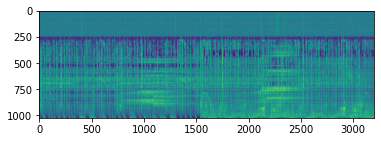

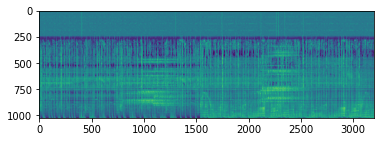

In [211]:
#spec = spec / (spec.std(-1, keepdims=True) + 1)
#plt.imshow(np.log(1+np.abs(spec[:,::-1].T)))

plt.imshow(np.log(0.001+np.abs(spec[:,::-1].T)))
plt.show()
plt.imshow(np.log(0.001+np.abs(phase[:,::-1].T)))
plt.show()

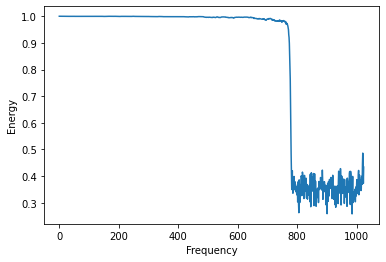

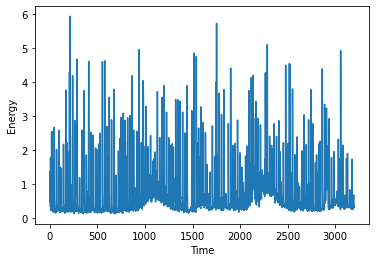

In [212]:
plt.plot(spec.std(0))
plt.xlabel("Frequency")
plt.ylabel("Energy")
plt.show()
plt.plot(spec.std(1))
plt.xlabel("Time")
plt.ylabel("Energy")
plt.show()

In [213]:
spec.min(), spec.max(), spec.mean(), spec.std()

(-28.185694, 29.157053, -5.7128627e-06, 0.88534915)

We can use these spectrograms as input for the decoder. However the values in the low frequencies have a super large scale

# Model

In [218]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense
# encoder
inp = tf.keras.layers.Input(shape=[40*sr])

# encoder preprocessing
inp = tf.keras.layers.Input(shape=[40*sr])
stft = tf.signal.stft(inp, sr//40, sr//80)
freq_scaler = tf.math.reduce_std(tf.math.real(stft), 1, keepdims=True) + 20
stft_real = tf.math.real(stft) / freq_scaler
stft_imag = tf.math.imag(stft) / freq_scaler
stft_2c = tf.stack([stft_real, stft_imag], axis=-1)
# shape: (time, freq:1025, channel:2)
x = Conv2D(512, kernel_size=(10, 1025), strides=(5, 1), padding='valid', activation='relu')(stft_2c)
x = Conv2D(512, kernel_size=(10, 1), strides=(5, 1), padding='same', activation='relu')(x)
x = Conv2D(512, kernel_size=(10, 1), strides=(2, 1), padding='same', activation='relu')(x)
x = Conv2D(512, kernel_size=(10, 1), strides=(2, 1), padding='same', activation='relu')(x)
x = Flatten()(x)
freq_scaler = Flatten()(freq_scaler)
x = tf.concat([x, freq_scaler], -1)
x = Dense(512)(x)
# encoder 1d convolutions
encoder = Model(inp, x)

encoder.inputs, encoder.outputs


([<tf.Tensor 'input_64:0' shape=(None, 1764000) dtype=float32>],
 [<tf.Tensor 'dense_2/Identity:0' shape=(None, 512) dtype=float32>,
  <tf.Tensor 'flatten_14/Identity:0' shape=(None, 1025) dtype=float32>])

In [145]:
882000/(318*512)

5.417158018867925

In [ ]:



# You can use SinusodialRepresentationDense exactly like you ordinarily use Dense layers.
ip = tf.keras.layers.Input(shape=[2])
x = SinusodialRepresentationDense(32,
                                  activation='sine', # default activation function
                                  w0=1.0)(ip)        # w0 represents sin(w0 * x) where x is the input.
                                  
model = tf.keras.Model(inputs=ip, outputs=x)

# Or directly use the model class to build a multi layer SIREN
model = SIRENModel(units=256, final_units=3, final_activation='sigmoid',
                   num_layers=5, w0=1.0, w0_initial=30.0)